In [2]:
import onshape as brepio
from mechanical.visualize2 import plot_assembly, filter_assembly
import os
import pandas as ps
import ipywidgets as widgets
from ipywidgets.embed import embed_minimal_html
from IPython.display import clear_output
import importlib
from IPython.display import display

In [3]:
df_name = '/fast/jamesn8/assembly_data/assembly_data_with_transforms_all.h5'
df_name_part = '/fast/jamesn8/assembly_data/assembly_data_with_transforms_all.h5_segmentation.h5'
assembly_df = ps.read_hdf(df_name,'assembly')
part_df = ps.read_hdf(df_name_part,'part')
mate_df = ps.read_hdf(df_name,'mate')
mate_df_by_ass = mate_df.copy()
mate_df_by_ass = mate_df.set_index('Assembly')
mate_df_by_ass['MateIndex'] = mate_df.index

path_to_index = ps.Series(dict((v,k) for k,v in assembly_df['AssemblyPath'].iteritems()))

has_geometry = part_df.groupby('Assembly')['HasGeometry'].agg(all)
assembly_df['HasAllGeometry'] = has_geometry

part_df.set_index('Assembly', inplace=True)

datapath = '/projects/grail/benjones/cadlab'
loader = brepio.Loader(datapath)

In [32]:
use_pspy = True
mate_types = ['PIN_SLOT', 'BALL', 'PARALLEL', 'SLIDER', 'REVOLUTE', 'CYLINDRICAL', 'PLANAR', 'FASTENED']
@widgets.interact(sample="7492")
def display_sample(sample):
    try:
        sample = int(sample)
    except ValueError:
        sample = path_to_index[sample]
    assemblypath = assembly_df.loc[sample, "AssemblyPath"]
    did, mv, eid = assemblypath.split('_')
    print(f'https://cad.onshape.com/documents/{did}/w/8a6b7ec29c9e253f04b1a1fb/m/{mv}/e/{eid}')
    print(assemblypath, f' ({sample})')
    try:
        geo, mates = loader.load_flattened(assemblypath + '.json', skipInvalid=True, use_pspy=use_pspy)
        mates = [mate for mate in mates if len(mate.matedEntities) == 2]
    except FileNotFoundError as e:
        print(f'File not found: {e}')
        return
    assert(list(geo) == list(part_df.loc[sample,'PartOccurrenceID']))
    mate_counts = dict()
    for mate in mates:
        if len(mate.matedEntities) == 2:
            if mate.type not in mate_counts:
                mate_counts[mate.type] = 0
            mate_counts[mate.type] += 1
    num_connected = assembly_df.loc[sample, "ConnectedComponents"]
    num_rigid = assembly_df.loc[sample, "RigidPieces"]
    if num_connected > 1:
        print('warning:',num_connected,'connected components')
    print('rigid pieces:',num_rigid)
    print('total parts:',len(geo))
    print(f'mates: {len(mates)}: ',mate_counts)

    mate_subset = mate_df_by_ass.loc[[sample]]
    geo_to_id = {occ: i for i,occ in enumerate(geo)}
    print(geo_to_id)
    print([(len(mate.matedEntities),mate.type) for mate in mates])
    pairs = [(geo_to_id[mate.matedEntities[0][0]],geo_to_id[mate.matedEntities[1][0]]) for mate in mates]
    choices = [(f'mate ({pairs[i][0]},{pairs[i][1]}) (ID {mate_subset.iloc[i]["MateIndex"]}) ({mates[i].type}) ({mates[i].name})',i) for i in range(len(mates)) if len(mates[i].matedEntities) == 2]
    choices = [('fullAssembly', -1)] + choices
    @widgets.interact(mate=choices)
    def display_subset(mate):
        rigid_labels = list(part_df.loc[sample, 'RigidComponentID'])
        nonlocal geo, mates
        if mate >= 0:
            print(pairs[mate])
            geo_filtered, mates_filtered = filter_assembly(geo, mates, pairs[mate])
            rigid_labels = [r for i,r in enumerate(rigid_labels) if i in pairs[mate]]
        else:
            geo_filtered = geo
            mates_filtered = mates
        badOccs = [k for k in geo if geo[k][1] is None or (geo[k][1].mesh.V if use_pspy else geo[k][1].V).shape[0] == 0]
        if len(badOccs) > 0:
            print(f'warning: {len(badOccs)} invalid parts!')
        #for o in badOccs:
        #    geo.pop(o)
        renderer = plot_assembly(geo_filtered, mates_filtered, rigid_labels = rigid_labels if mate < 0 else None)
        display(renderer)
        #embed_minimal_html('export.html', views=[renderer], title='Viewer export')
            #print('num mates:',len(mates))
    

interactive(children=(Text(value='7492', description='sample'), Output()), _dom_classes=('widget-interact',))

In [87]:
mate_df.loc[9484]

Assembly                                                  552
Part1                                       M1/dZMrxY1lIcRFnx
Part2                                       MiEfLhvfBX5+WwTK1
Type                                                 REVOLUTE
Origin1                              [0.000762, -0.0762, 0.0]
Axes1       [[0.0, 0.0, -1.0], [1.0, 0.0, 0.0], [0.0, -1.0...
Origin2                         [-4.440892e-16, -0.0762, 0.0]
Axes2       [[0.0, 0.0, -1.0], [0.0, 1.0, -0.0], [1.0, 0.0...
Name                                               Revolute 2
Name: 9484, dtype: object

In [89]:
part_df.loc[552]

,PartOccurrenceID,did,mv,eid,config,PartId,Transform,HasGeometry,RigidComponentID
Assembly,,,,,,,,,
552,MRPqM9QevOxx309ic,58a198fcf9c56c0fcc305b81,bbdc6bd06863df20683a15cb,6a008579cc8f18301d71453c,default,JHD,"[[1.0, 0.0, 0.0, -0.021967174], [0.0, 1.0, 0.0...",True,0
552,MmA7eFgBYnf7yOODU,58a198fcf9c56c0fcc305b81,bbdc6bd06863df20683a15cb,6a008579cc8f18301d71453c,default,RBBD,"[[0.0, -1.0, 0.0, -0.015617174], [1.0, 0.0, 0....",True,0
552,M59OywwaIElzsyE8k,58a198fcf9c56c0fcc305b81,bbdc6bd06863df20683a15cb,6a008579cc8f18301d71453c,default,JjD,"[[1.0, 0.0, -1.2246469e-16, -0.021967174], [0....",True,0
552,M1/dZMrxY1lIcRFnx,58a198fcf9c56c0fcc305b81,bbdc6bd06863df20683a15cb,6a008579cc8f18301d71453c,default,RpBD,"[[-0.92174846, -0.29050457, -0.25687918, -0.04...",True,1
552,MiEfLhvfBX5+WwTK1,58a198fcf9c56c0fcc305b81,bbdc6bd06863df20683a15cb,6a008579cc8f18301d71453c,default,RNBD,"[[-0.92174846, 3.5414365e-16, 0.38778836, -0.0...",True,2
552,Mwuf6NDWDinzVdlEU,58a198fcf9c56c0fcc305b81,bbdc6bd06863df20683a15cb,6a008579cc8f18301d71453c,default,RFBD,"[[1.0, 0.0, -1.2246469e-16, -0.021967174], [0....",True,3
552,MtEBUiiw8jvjVvQLI,58a198fcf9c56c0fcc305b81,bbdc6bd06863df20683a15cb,6a008579cc8f18301d71453c,default,RzBD,"[[1.0, 0.0, 0.0, -0.021967174], [0.0, 1.0, 0.0...",True,0


In [16]:
with open('/projects/grail/jamesn8/projects/mechanical/Mechanical/data/dataset/invalid_threshold_0_25.txt','r') as f:
    invalid_asses = [int(l) for l in f.readlines()]

with open('/projects/grail/jamesn8/projects/mechanical/Mechanical/data/dataset/random_excludes.txt','r') as f:
    random_asses = [int(l) for l in f.readlines()]

with open('/projects/grail/jamesn8/projects/mechanical/Mechanical/data/dataset/clean_dataset_with_augmented_fastens.txt','r') as f:
    all_asses = [int(l) for l in f.readlines()]

    

<AxesSubplot:>

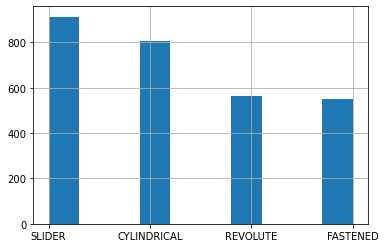

In [26]:
mate_df.set_index('Assembly').loc[invalid_asses]['Type'].hist()

<AxesSubplot:>

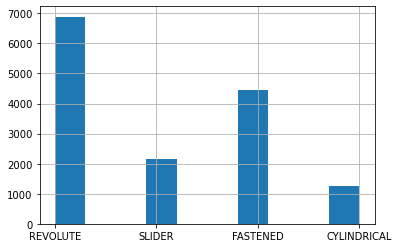

In [25]:
mate_df.set_index('Assembly').loc[set(all_asses).difference(set(invalid_asses))]['Type'].hist()

<AxesSubplot:>

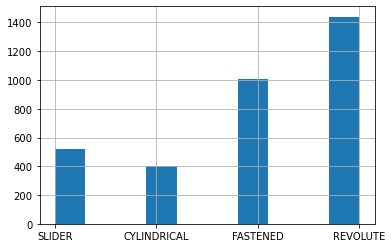

In [22]:
mate_df.set_index('Assembly').loc[random_asses]['Type'].hist()

<AxesSubplot:>

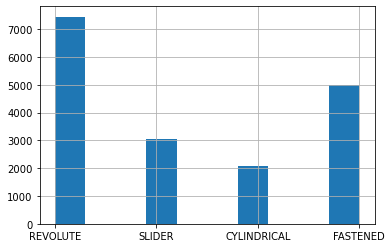

In [24]:
mate_df.set_index('Assembly').loc[all_asses]['Type'].hist()

In [15]:
(len(invalid_asses)/6448)

0.18889578163771711

In [20]:
#invalid
2832  / 17574 

0.1611471491976784

In [21]:
#random
3373 / 17574 

0.19193126209172642

In [27]:
6448 - len(invalid_asses)

5230